# Azhar Rizki Zulma

Dataset: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria



## **Data Preparation**
### Import Library

In [1]:
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow import keras
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

### Menginstall Kaggle

In [2]:
!pip install -q kaggle

### Upload Kredensial (Token API)

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Konfigurasi untuk menerima datasets dari Kaggle

In [4]:
!chmod 600 /content/kaggle.json

### Download Dataset

In [5]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 671M/675M [00:09<00:00, 43.6MB/s]
100% 675M/675M [00:09<00:00, 71.1MB/s]


### Mengekstrak Dataset

In [6]:
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Mendeklarasikan Direktori Dasar

In [7]:
BASE_DIR = '/content/cell_images/'

### Membuat fungsi list_files untuk mengidentifikasi jumlah file

In [8]:
def list_files(startpath):
  num_files = 0
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 2 * (level)
    num_files += len(files)
    print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))
  
  return num_files

### Memanggil fungsi list_files dengan parameter variabel direktori dasar yang telah dibuat sebelumnya

In [9]:
list_files(BASE_DIR)

/ 
Uninfected/ 13780 images
cell_images/ 
  Uninfected/ 13780 images
  Parasitized/ 13780 images
Parasitized/ 13780 images


55120

### Membuat fungsi read_files untuk membaca setiap files

In [10]:
def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))
  
  return image_files

### Menghapus file yang tidak digunakan

In [11]:
os.remove("/content/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/Uninfected/Thumbs.db")
os.remove("/content/cell_images/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/cell_images/Uninfected/Thumbs.db")

### Memastikan ukuran image yang beragam dengan fungsi PIL

In [12]:
full_dirs = read_files(BASE_DIR + "cell_images")
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 27558
Size unique images: 1627
First 10 unique images: 
['112x157', '124x115', '151x169', '184x163', '187x184', '124x142', '103x82', '136x127', '85x127', '133x172']


Terdapat 27558 gambar dan 1627 diantaranya memiliki ukuran yang beragam

## **Data Preprocessing dan Data Splitting**

### Melakukan Augmentasi Gambar

In [13]:
datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=0.2
)

### Data Image Generator

In [14]:
training_generator = datagen.flow_from_directory(
  BASE_DIR + "cell_images",
  subset='training',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['Parasitized','Uninfected']
)

validation_generator = datagen.flow_from_directory(
  BASE_DIR + "cell_images",
  subset='validation',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['Parasitized','Uninfected']
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## **Modelling & Training**

In [15]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.6),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 92%!")
callbacks = myCallback()

LR = 1e-4
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=LR),
              metrics=['accuracy'])

result = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=150,
    validation_steps=35,
    callbacks=[callbacks],
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       7

## **Plot Accuracy & Loss**

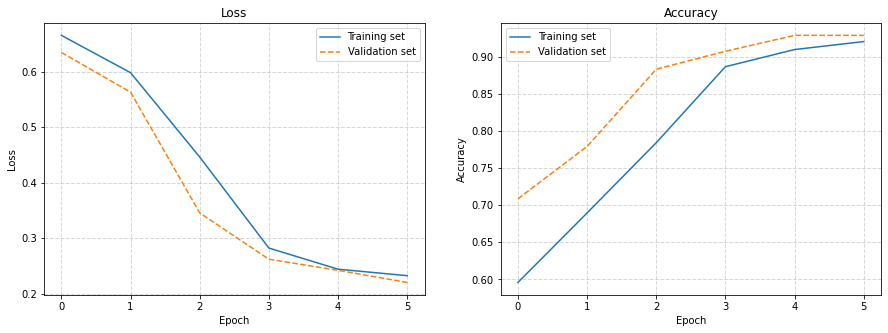

In [16]:
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## **Convert to TFLite**

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp94jzyh2_/assets


In [18]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)